In [1]:
import os, random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler

from scipy.signal import resample

In [26]:
SAMPLE_POINTS = 50
INPUT_PARAMETERS = 2

SCRIPT_DIR = os.path.abspath('') #os.path.dirname(__file__); workaround for jupyter notebook

TRAIN_PATH = os.path.join(SCRIPT_DIR, "dataset/train")
TEST_PATH = os.path.join(SCRIPT_DIR, "dataset/test")

In [6]:
train_data: list[tuple[str, list[tuple]]] = []
test_data: list[tuple[str, list[tuple]]] = []

In [16]:
def get_files(path: str, data_list: list) -> None:
  for root, _, files in os.walk(path):
    if len(files) == 0:
      continue

    for file_name in files:
      if not file_name.endswith(".csv"):
        continue

      class_name = os.path.basename(root)
      file_path = os.path.join(path, class_name, file_name)

      data = pd.read_csv(filepath_or_buffer=file_path, delimiter=",")

      points = data[["x", "y"]]
      points = np.array(points, dtype=float)

      scaler = StandardScaler()
      points = scaler.fit_transform(points)

      points_resampled = resample(points, SAMPLE_POINTS)

      data_list.append((class_name, points_resampled))

In [20]:
get_files(TRAIN_PATH, train_data)
get_files(TEST_PATH, test_data)

In [22]:
print(test_data[0])

('arrow', array([[-2.178185  ,  0.99153124],
       [-2.26776259,  0.59211023],
       [-2.14967226,  0.73088799],
       [-1.98410903,  0.64462215],
       [-1.80649644,  0.69713812],
       [-1.56667251,  0.51236003],
       [-1.43484472,  0.58330645],
       [-1.23745443,  0.49344059],
       [-0.93565804,  0.41587817],
       [-0.52874398,  0.41704268],
       [-0.18174767,  0.43173345],
       [ 0.19102   ,  0.48780311],
       [ 0.46613195,  0.39719951],
       [ 0.76464554,  0.44686147],
       [ 0.94609066,  0.55979266],
       [ 1.11061219,  0.50775328],
       [ 1.18582344,  0.49832166],
       [ 1.20542192,  0.34802311],
       [ 1.07365091,  0.16298419],
       [ 1.00507662,  0.01527042],
       [ 0.84977166, -0.12242082],
       [ 0.72371717, -0.4063493 ],
       [ 0.5345283 , -0.65575508],
       [ 0.44517207, -0.7155519 ],
       [ 0.27524691, -0.82320905],
       [ 0.1360282 , -1.06518026],
       [-0.07467341, -1.16571298],
       [-0.12144915, -1.21596079],
       [-0

In [28]:
def split_data(data: list[tuple[str, list[tuple]]]) -> tuple[np.ndarray, np.ndarray, list[str]]:
  labels = [sample[0] for sample in data]
  print(set(labels))

  encoder = LabelEncoder()
  labels_encoded = encoder.fit_transform(labels)

  print(set(labels_encoded))

  y = to_categorical(labels_encoded)

  print(len(y[0]))

  sequences = [sample[1] for sample in data]
  X = np.array(sequences)

  return X, y, labels

In [29]:
X_train, y_train, labels_train = split_data(train_data)
X_test, y_test, labels_test = split_data(test_data)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

{'circle', 'question_mark', 'triangle', 'right_sq_bracket', 'delete_mark', 'v', 'star', 'caret', 'x', 'arrow', 'check', 'left_curly_brace', 'left_sq_bracket', 'rectangle', 'right_curly_brace', 'pigtail'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
16
{'circle', 'question_mark', 'triangle', 'right_sq_bracket', 'delete_mark', 'v', 'star', 'caret', 'x', 'arrow', 'check', 'left_curly_brace', 'left_sq_bracket', 'rectangle', 'right_curly_brace', 'pigtail'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
16
(5120, 50, 2) (320, 50, 2) (5120, 16) (320, 16)


# 1) LSTM Approach

In [31]:
model = Sequential()

model.add(LSTM(64, input_shape=(SAMPLE_POINTS, INPUT_PARAMETERS)))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(set(labels_train)), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [32]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/10
160/160 [==============================] - 4s 13ms/step - loss: 1.2834 - accuracy: 0.6031 - val_loss: 0.2684 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 2/10
160/160 [==============================] - 2s 10ms/step - loss: 0.1470 - accuracy: 0.9684 - val_loss: 0.0813 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 3/10
160/160 [==============================] - 2s 10ms/step - loss: 0.0719 - accuracy: 0.9814 - val_loss: 0.1815 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 4/10
160/160 [==============================] - 2s 10ms/step - loss: 0.0637 - accuracy: 0.9838 - val_loss: 0.0619 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 5/10
160/160 [==============================] - 2s 11ms/step - loss: 0.0454 - accuracy: 0.9891 - val_loss: 0.0428 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 6/10
160/160 [==============================] - 2s 10ms/step - loss: 0.0467 - accuracy: 0.9885 - val_loss: 0.0249 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 7/10
160/160 [==============================] - 2s 10ms/st

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
Total params: 19,760
Trainable params: 19,760
Non-trainable params: 0
_________________________________________________________________


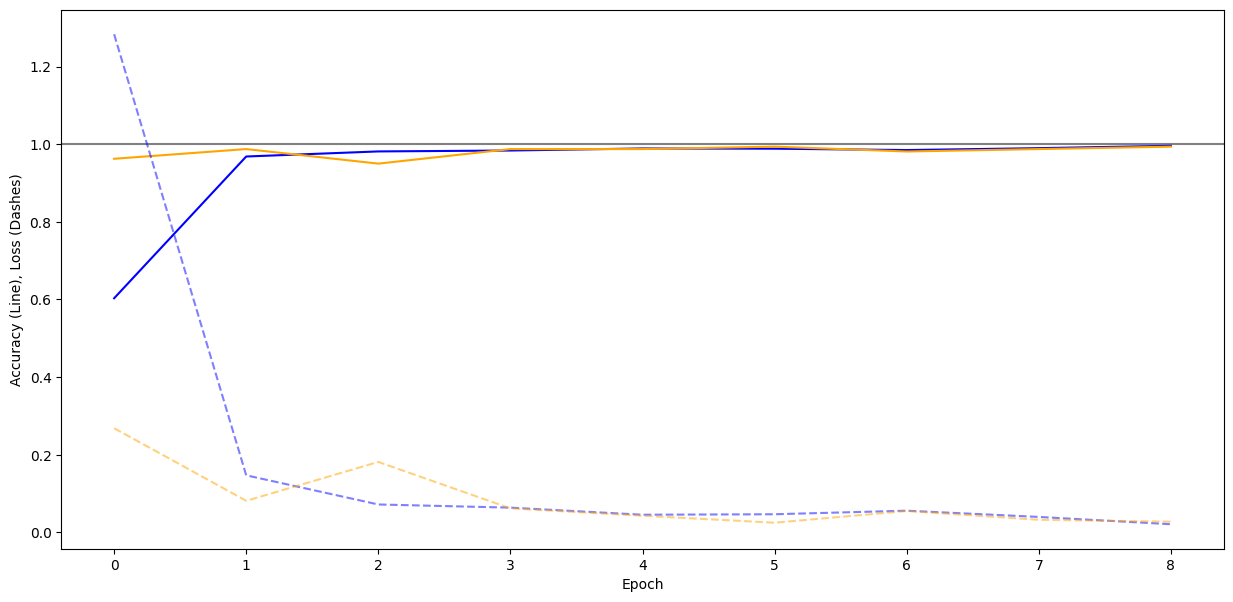

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

10/10 [==============================] - 1s 5ms/step


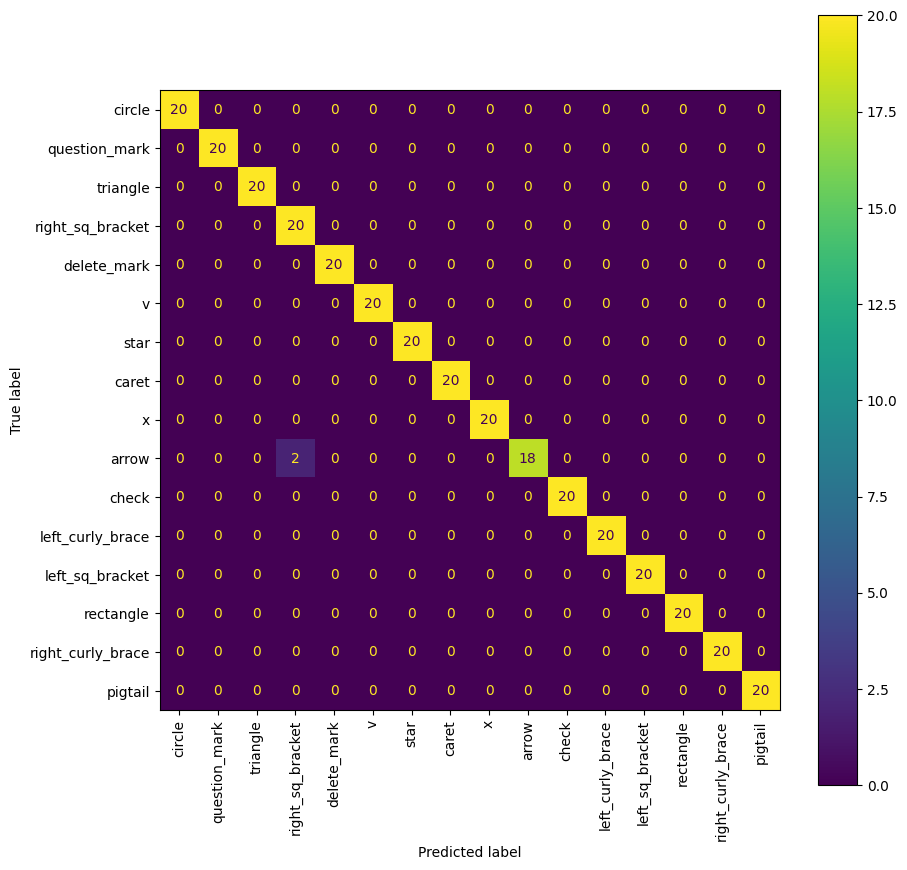

In [35]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels_train)).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

# 2) 1$ Recogniser Approach